In [1]:
import pytorch_hyperlight as pth
import torch
from pytorch_hyperlight.tasks.nst import (
    LitVGG19StyleTransfer,
    NSTImageUrlOrPathDataLoader,
)
from pytorch_hyperlight.utils.image_utils import (
    save_image_tensor_to_url,
    show_image_tensors,
)

We will use rectangular images (as we strip out fully-connected layer of VGG), that is why we fix only the height of the image

In [2]:
EXPERIMENT_ID = "Plain_Simple_NST"

In [3]:
FAST_DEV_RUN = False
TARGET_IMAGE_HEIGHT = 300

CONTENT_IMAGE_PATH_OR_URL = "https://images.unsplash.com/photo-1541426062085-72349d82d048?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&dl=evgeni-tcherkasski-tXFP68P6OGk-unsplash.jpg"
STYLE_IMAGE_PATH_OR_URL_LIST = [
    "http://c4.wallpaperflare.com/wallpaper/743/193/102/vincent-van-gogh-painting-the-starry-night-classic-art-wallpaper-preview.jpg"
]
STYLED_IMAGE_PATH_OR_URL = "./styled_image.png"

We use the content image as a source of aspect ratio, then the content image is scaled (without changing its aspect ratio), finally the style images are reshaped to match the size of the scaled content image

In [4]:
def configure_dataloaders(batch_size, n_workers=None):
    assert batch_size == 1
    #
    #  dummy samples serve the only purpose of reducing the epoch overhead of PyTorch-Lightning
    #  without dummy samples would only have a single sample in the dataset which would lead to
    #  incrementing the epoch number at each SGD step. Epoch increment causes an overhead of up to
    #  300ms in PyTorch Lightning. When N_DUMMY_SAMPLES> 1 and batch_size = 1 the epoch increment
    #  happens every N_DUMMY_SAMPLES samples
    #
    N_DUMMY_SAMPLES = 30

    # Since PyTorch-Lightning assumes is passed via dataloader we will create the dummy dataloader
    # with the single purpose of triggering the PyTorch-Lightning optimization loop. We will also assume
    # that our batch size is 1, number of steps per epoch is defined by N_DUMMY_SAMPLES.
    # This way we will minimize PyTorch-Lightning overhead (up to ~300ms per epoch) which would hit us
    # if we used 1 step per epoch.
    #
    image_dataloader = NSTImageUrlOrPathDataLoader(
        N_DUMMY_SAMPLES,
        TARGET_IMAGE_HEIGHT,
        CONTENT_IMAGE_PATH_OR_URL,
        STYLE_IMAGE_PATH_OR_URL_LIST,
    )
    return {"train_loader": image_dataloader}

In [5]:
batch = next(iter(configure_dataloaders(1)["train_loader"]))

In [6]:
CONTENT_IMAGE_TENSOR_SIZE_LIST = list(batch[0].shape)[1:]

In [7]:
# all batches except for the first one are dummy batches
# each batch is a tuple of two elements:  (content_image, style_image_list)
#
content_image_tensor = batch[0]
style_image_tensor_list = batch[1]
image_tensor_list = [content_image_tensor] + style_image_tensor_list
image_description_list = ["content"] + ["style"] * len(style_image_tensor_list)

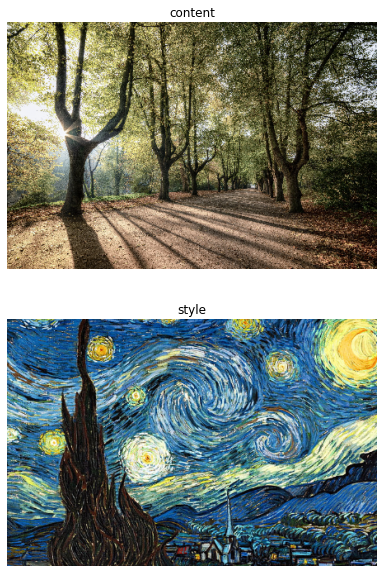

In [8]:
show_image_tensors(
    image_tensor_list,
    image_description_list,
)

In [9]:
IS_CUDA = torch.cuda.is_available()

CONFIG = {
    "lr": 7e-2,  # Initial learning rate
    "max_epochs": 50,  # the actual number can be less due to early stopping
    "batch_size": 1,
}

TUNE_CONFIG = {
    "seed": 16,  # just remove this if you do not want determenistic behavior
    "metric_to_optimize": "train_total_loss_epoch",  # Ray + PTL Trainer
    "ray_metrics_to_show": [
        "train_total_loss_epoch",
    ],  # for Ray Tune
    "metric_opt_mode": "min",  # Ray + PTL Trainer
    "cpu_per_trial": 3,  # Ray + DataLoaders
    #    "gpu_per_trial": 1,  # for Ray Tune
    #    "n_checkpoints_to_keep": 1,  # for Ray Tune
    "grace_period": 0,  # for both PTL Trainer and Ray Tune scheduler
    #    "epoch_upper_limit": 45,  # for Ray Tune
    #    "n_samples": 3,  # for Ray Tune
    "ptl_early_stopping_patience": 5,  # for PTL Trainer
    "ptl_precision": 32,  # or 16, for PTL Trainer
    "train_loader_name": "train_loader",
    "val_loader_name": None,
    "test_loader_name": None,
    "batch_size_main": CONFIG[
        "batch_size"
    ],  # batch size for revalidation and test phases
    #    that run in the main process after all Ray Tune child processes are finished
    "gpus": -1 * IS_CUDA,  # -1 - use GPU if available, 0 - use CPU, 1 - use single GPU,
    # "gpus": 0,
    # >=2 - use multiple GPUs
}

if FAST_DEV_RUN:
    CONFIG["max_epochs"] = 2
    TUNE_CONFIG["n_samples"] = 2

runner = pth.Runner(
    configure_dataloaders,
    is_debug=FAST_DEV_RUN,
    experiment_id=EXPERIMENT_ID,
    log2wandb=False,
)

In [10]:
config_dict = {
    **CONFIG,
    "style_merge_method": "plain_merge",
    "content_layer_name_list": ["conv3_1"],
    "style_layer_name_list": [
        "conv1_1",
        "conv1_2",
        "conv2_1",
        "conv2_2",
        "conv3_1",
    ],
    "content_weight": 1e-5,
    "style_weight_list": [1e4],
    "gradient_clip_val": 0,
    "varying_image_tensor_size_list": CONTENT_IMAGE_TENSOR_SIZE_LIST,
}

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 16
Global seed set to 16

  | Name       | Type      | Params
-----------------------------------------
0 | loss_model | LossModel | 555 K 
-----------------------------------------
404 K     Trainable params
555 K     Non-trainable params
959 K     Total params
/home/peter/.conda/envs/ml-devenv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

/home/peter/.conda/envs/ml-devenv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: RuntimeWarning: You are using `LearningRateMonitor` callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.
  warnings.warn(*args, **kwargs)


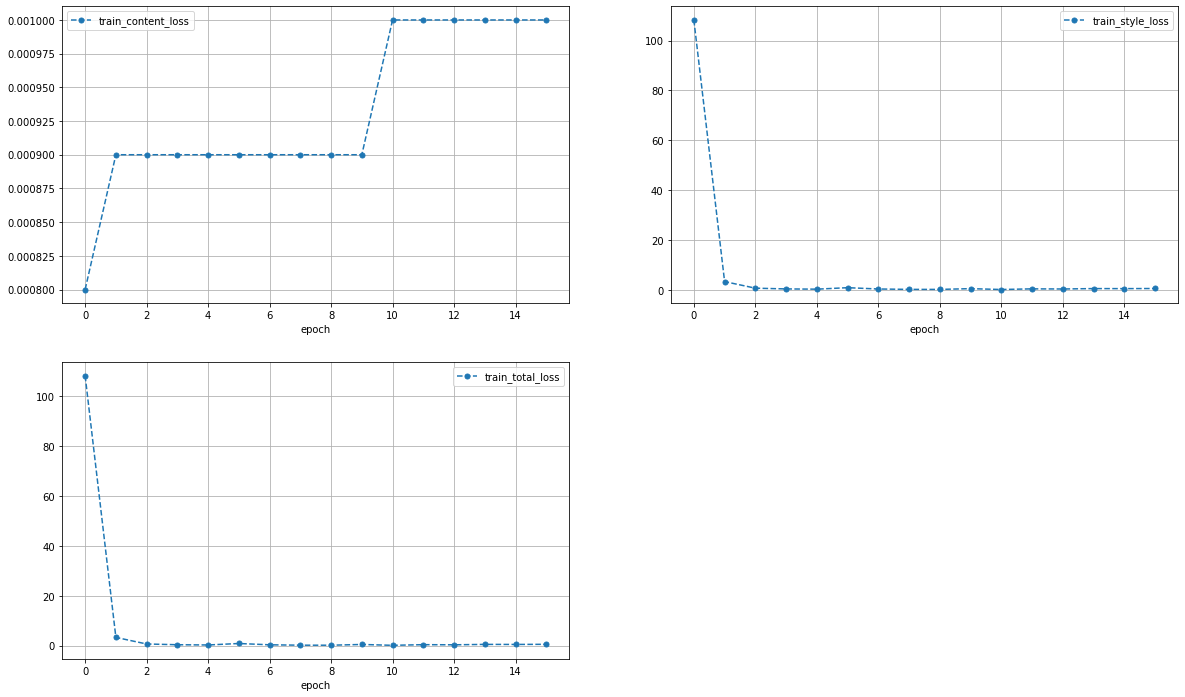

In [11]:
best_result = runner.run_single_trial(LitVGG19StyleTransfer, config_dict, TUNE_CONFIG)

In [12]:
styled_image_tensor = best_result["lmodule_best"].varying_image.detach()

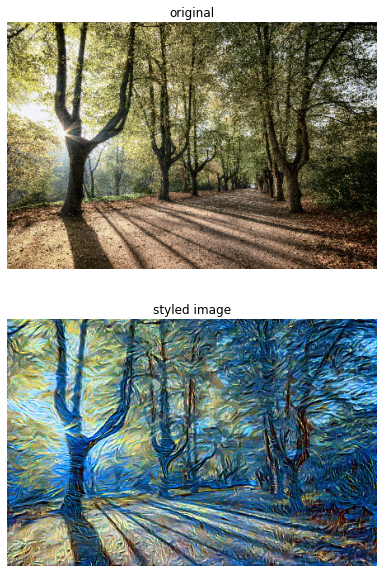

In [13]:
show_image_tensors(
    [content_image_tensor, styled_image_tensor],
    ["original", "styled image"],
)

In [14]:
save_image_tensor_to_url(styled_image_tensor[0], STYLED_IMAGE_PATH_OR_URL)